In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
from scipy.optimize import fsolve, differential_evolution, minimize
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial, c_s2, find_temp, T_vis_strongDW
from unchanged_values import r_au, sD1_log, Ω, T_req, color_use

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

## Disc wind mass flux $C_W$
### $C_{w,e}$ Disc wind mass flux constrained by energetics
$$C_{w,e}=max\left(\frac{2}{r^3\Omega(\rho c_s)_{mid}}\partial_r(r^2\Sigma\alpha_{r\phi}c_s^2)\;+\;\frac{2c_s}{r\Omega}α_{φz},\;0\right)$$
$$(\rho c_s)_{mid} = \frac{1}{\sqrt{2\pi}}\Sigma \Omega$$
### $C_{w,0}$ A constant size constrained by the density at the midplane $\alpha_{r\phi}$
*For MRI-inactive $\alpha_{r\phi} = 8\cdot10^{-5}$:*
$$C_{w,0}=10^{-5}$$

$$C_W = \text{min}(C_{w,0},\;C_{w,e})$$

# Disc wind torque $\alpha_{\phi z}$
### Zero-torque:
$$\alpha_{\phi z}=0$$
### Constant-torque:
$$\alpha_{\phi z} = 10^{-4}$$
### $\Sigma$-dependent torque:
$$\alpha_{\phi z} = \text{min}\left(10^{-5}\left(\frac{\Sigma}{\Sigma_{int}}\right)^{-0.66},\;1\right)$$

In [2]:
def α_φz_func(Σ):
    Σ_relation = 1e-5 * (Σ / Σ_initial(r_au))**(-0.66)
    Σ_relation = np.minimum(Σ_relation, 1)
    return Σ_relation

In [3]:
def ρ_cs_mid(Σ):
    return ((2 * np.pi)**(-0.5) * Σ * Ω).decompose()   

In [4]:
ρ_cs_mid(Σ_initial(r_au))

<Quantity [1.34983884e+004, 1.17509886e+004, 1.02297865e+004,
           8.90550169e+003, 7.75264429e+003, 6.74902370e+003,
           5.87532181e+003, 5.11472110e+003, 4.45258099e+003,
           3.87615604e+003, 3.37435062e+003, 2.93750538e+003,
           2.55721134e+003, 2.22614800e+003, 1.93794248e+003,
           1.68704684e+003, 1.46863130e+003, 1.27849129e+003,
           1.11296649e+003, 9.68870411e+002, 8.43429047e+002,
           7.34227481e+002, 6.39163405e+002, 5.56406652e+002,
           4.84363971e+002, 4.21648356e+002, 3.67052351e+002,
           3.19524807e+002, 2.78150648e+002, 2.42133257e+002,
           2.10779141e+002, 1.83484584e+002, 1.59724022e+002,
           1.39039929e+002, 1.21034009e+002, 1.05359527e+002,
           9.17146356e+001, 7.98365660e+001, 6.94965657e+001,
           6.04954971e+001, 5.26600032e+001, 4.58391706e+001,
           3.99016234e+001, 3.47329944e+001, 3.02337233e+001,
           2.63171394e+001, 2.29077932e+001, 1.99400039e+001,
        

In [5]:
α_rφ = 8e-5
'''ρ_cs_mid(Σ_initial(r_au))
def part1(Σ):
    return 2 * ((r_au**3 * Ω * ρ_cs_mid(Σ))**(-1)).decompose()

def part2(Σ, T):
    to_dev = (r_au**2 * Σ * α_rφ * c_s2(T)).decompose()
    return (r_au**(-1) * (sD1_log @ to_dev) * to_dev.unit).decompose()

def part3(T, α_φz):
    return ((2 * np.sqrt(c_s2(T))) / (r_au * Ω) * α_φz).decompose()

C = part1(Σ_initial(r_au)) * part2(Σ_initial(r_au), T_req) + part3(T_req, 1e-5)'''


'ρ_cs_mid(Σ_initial(r_au))\ndef part1(Σ):\n    return 2 * ((r_au**3 * Ω * ρ_cs_mid(Σ))**(-1)).decompose()\n\ndef part2(Σ, T):\n    to_dev = (r_au**2 * Σ * α_rφ * c_s2(T)).decompose()\n    return (r_au**(-1) * (sD1_log @ to_dev) * to_dev.unit).decompose()\n\ndef part3(T, α_φz):\n    return ((2 * np.sqrt(c_s2(T))) / (r_au * Ω) * α_φz).decompose()\n\nC = part1(Σ_initial(r_au)) * part2(Σ_initial(r_au), T_req) + part3(T_req, 1e-5)'

In [6]:
def C_we(Σ, T, α_φz, α_rφ = 8e-5):
    def part1(Σ):
        return 2 * ((r_au**3 * Ω * ρ_cs_mid(Σ))**(-1)).decompose()

    def part2(Σ, T):
        to_dev = (r_au**2 * Σ * α_rφ * c_s2(T)).decompose()
        return (r_au**(-1) * (sD1_log @ to_dev) * to_dev.unit).decompose()

    def part3(T, α_φz):
        return ((2 * np.sqrt(c_s2(T))) / (r_au * Ω) * α_φz).decompose()
    
    C_we = (part1(Σ) * part2(Σ, T)) + part3(T, α_φz)
    #C_we = np.maximum(C_we, 0)

    return C_we, part1(Σ).decompose(), part2(Σ, T).decompose(), part3(T, α_φz).decompose()    

In [7]:
def C_w(Σ, T, α_φz, Cw0 = 1e-5):
    Cw0 = Cw0 * np.ones_like(r_au.value)
    C_W = np.minimum(Cw0, C_we(Σ, T, α_φz)[0])
    return C_W

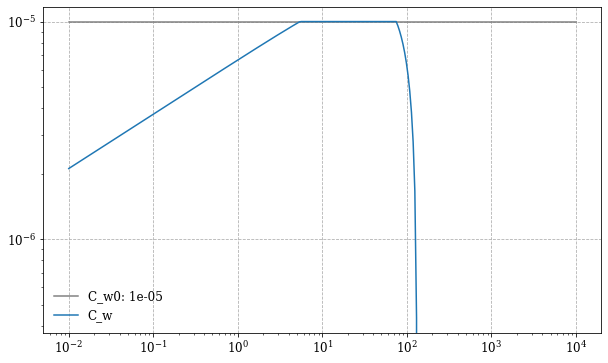

In [8]:
fig, axs = plt.subplots(figsize = (10, 6))
axs.grid(ls='--')

axs.loglog(r_au, 1e-5 * np.ones_like(r_au), c='grey', label = f'C_w0: {1e-5}')
axs.loglog(r_au, C_w(Σ_initial(r_au), T_req, 1e-4), label= f'C_w')


plt.legend(frameon=False)

In [9]:
temp_initial = find_temp(10001, T_req, T_vis_strongDW)

100%|██████████| 10001/10001 [00:16<00:00, 597.63it/s]


In [10]:
C_w_sDW_constant_torque = C_w(Σ_initial(r_au), temp_initial, 1e-4)
C_w_sDW_zero_torque = C_w(Σ_initial(r_au), temp_initial, 0)
C_w_sDW_Σdepen_torque = C_w(Σ_initial(r_au), temp_initial, α_φz_func(Σ_initial(r_au)))

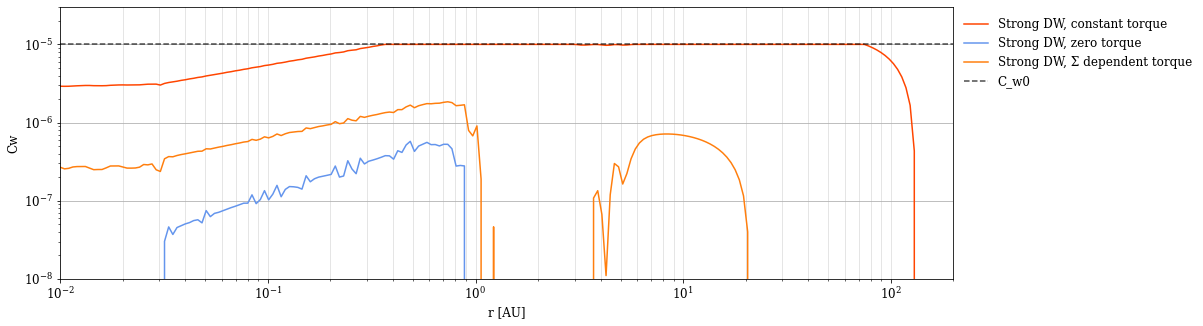

In [11]:
fig, axs = plt.subplots(figsize = (16,5))
axs.grid(which = 'major', axis= 'y')
axs.grid(which = 'both', axis= 'x', alpha = 0.4)


axs.loglog(r_au, C_w_sDW_constant_torque, c=color_use[0], label = 'Strong DW, constant torque')
axs.loglog(r_au, C_w_sDW_zero_torque, c=color_use[1], label = 'Strong DW, zero torque')
axs.loglog(r_au, C_w_sDW_Σdepen_torque, c=color_use[2], label = 'Strong DW, Σ dependent torque')
axs.set(ylim = (1e-8, 3e-5), xlim = (0.01, 200), ylabel = 'Cw', xlabel='r [AU]')
axs.axhline(1e-5, c = 'black', ls = '--', label = 'C_w0', alpha = 0.7)
axs.legend(frameon = False, bbox_to_anchor = (1,1))



In [12]:
sDW_Σtorque = C_we(Σ_initial(r_au), temp_initial, 0)
np.shape(sDW_Σtorque)

(4, 300)

In [13]:
negative_index = np.where(sDW_Σtorque[1] * sDW_Σtorque[2] < 0 )
product = sDW_Σtorque[1] * sDW_Σtorque[2]

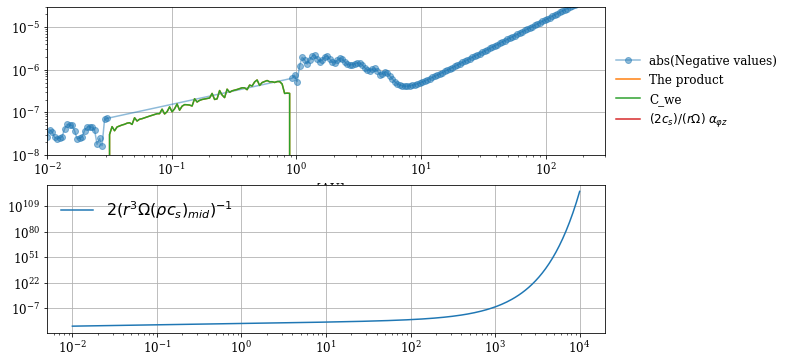

In [14]:
fig, axs = plt.subplots(2, 1, figsize = (10, 6))
axs[0].grid()

axs[0].loglog(r_au[negative_index], abs(product[negative_index]), 'o-',label = 'abs(Negative values)', alpha = 0.5)
axs[0].loglog(r_au, product, label = 'The product')
axs[0].loglog(r_au, sDW_Σtorque[1] * sDW_Σtorque[2] + sDW_Σtorque[3], label = 'C_we')
#axs.loglog(r_au, sDW_Σtorque[2], label = '$\partial_r(r^2ΣΩα_{rφ}c_s^2)$')
axs[0].loglog(r_au, sDW_Σtorque[3], label = '$(2c_s)/(rΩ)\;α_{φz}$')

axs[0].set(ylim = (1e-8, 3e-5), xlim = (0.01, 300), xlabel='r [AU]')
#axs.axhline(1e-5, c = 'black', ls = '--', label = 'C_w0', alpha = 0.7)
axs[0].legend(frameon = False, bbox_to_anchor = (1,0.75))

axs[1].grid()
axs[1].loglog(r_au, sDW_Σtorque[1], label = '$2(r^3Ω(ρc_s)_{mid})^{-1}$')
axs[1].legend(frameon = False, prop = {'size':16})

<function matplotlib.pyplot.savefig(*args, **kwargs)>

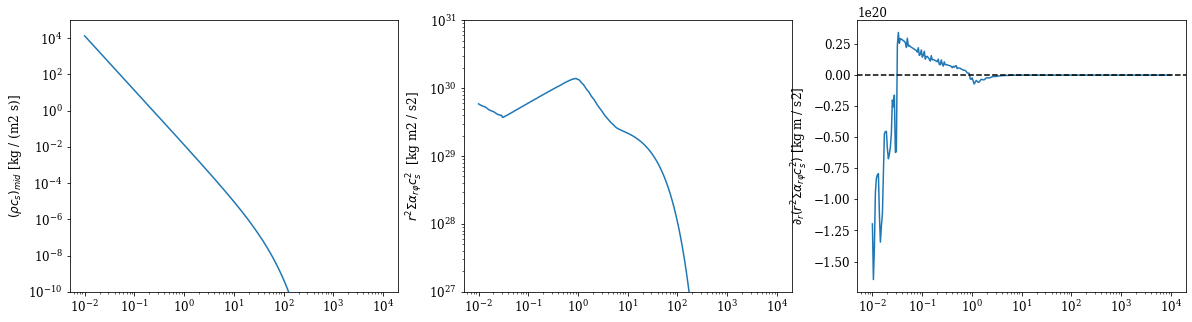

In [15]:
fig, axs = plt.subplots(1,3, figsize = (20, 5))


axs[0].loglog(r_au, ρ_cs_mid(Σ_initial(r_au)), label = 'ρ_cs__mid')
axs[0].set(ylabel = '$(ρc_s)_{mid}$'+f' [{ρ_cs_mid(Σ_initial(r_au)).unit}]', ylim = (1e-10, 1e5))

to_dev = (r_au**2 * Σ_initial(r_au) * α_rφ * c_s2(temp_initial)).decompose()
axs[1].loglog(r_au, to_dev)
axs[1].set(ylabel = '$r^2Σα_{rφ}c_s^2$'+f'  [{to_dev.unit}]', ylim = (1e27, 1e31))

dev = (r_au**(-1) * (sD1_log @ to_dev) * to_dev.unit).decompose()
axs[2].semilogx(r_au, dev)
axs[2].set(ylabel = '$\partial_r(r^2Σα_{rφ}c_s^2)$'+f' [{dev.unit}]')
axs[2].axhline(0, ls='--', c = 'black')

plt.savefig

(0.01, 1000000000000.0)

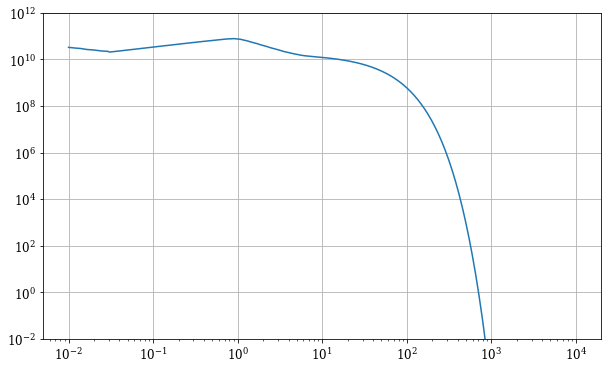

In [19]:
plt.figure(figsize=(10,6))
plt.grid()

#plt.loglog(r_au, temp_initial * r_au**0.5)
plt.loglog(r_au, Σ_initial(r_au) * r_au**2 * c_s2(temp_initial))
plt.ylim(1e-2, 1e12)